In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

Downloading the the dataset

In [4]:
raw_sp500 = yf.download("^GSPC", start="1927-01-01", interval="1d", auto_adjust=False)

# Keep only OHLCV columns (ignore Adj Close for now)
raw_sp500 = raw_sp500[["Open", "High", "Low", "Close", "Volume"]].copy()

print("Raw shape:", raw_sp500.shape)
raw_sp500.head()

[*********************100%***********************]  1 of 1 completed

Raw shape: (24612, 5)


Price,Open,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0


In [5]:
# Flatten MultiIndex columns
if isinstance(raw_sp500.columns, pd.MultiIndex):
    raw_sp500.columns = raw_sp500.columns.get_level_values(0)
raw_sp500.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0


Filtering the Dataset

In [6]:
sp500 = raw_sp500.copy()
sp500 = sp500.loc["1990-01-01":].copy()

print(sp500.shape)
print("Date range:", sp500.index.min(), "->", sp500.index.max())

(9062, 5)
Date range: 1990-01-02 00:00:00 -> 2025-12-23 00:00:00


Creating a Target 

In [7]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500[["Close", "Tomorrow", "Target"]].head()

Price,Close,Tomorrow,Target
Date,,,
1990-01-02,359.690002,358.760010,0
1990-01-03,358.760010,355.670013,0
1990-01-04,355.670013,352.200012,0
1990-01-05,352.200012,353.790009,1
1990-01-08,353.790009,349.619995,0


Feature Engineering 

In [8]:
sp500["ret_1d"] = sp500["Close"].pct_change()

# Lagged returns (momentum / mean-reversion signals)
for lag in [2, 3, 5, 10]:
    sp500[f"ret_{lag}d"] = sp500["Close"].pct_change(lag)

# Rolling average returns (trend strength)
for win in [5, 10, 20]:
    sp500[f"ret_mean_{win}d"] = sp500["ret_1d"].rolling(win).mean()

# Rolling volatility (risk/regime)
for win in [5, 10, 20]:
    sp500[f"ret_vol_{win}d"] = sp500["ret_1d"].rolling(win).std()

# Price vs moving average ratios (trend indicator)
for win in [10, 20, 50, 200]:
    ma = sp500["Close"].rolling(win).mean()
    sp500[f"close_to_sma_{win}d"] = sp500["Close"] / ma

In [9]:
# Intraday range features (volatility within the day)
sp500["range_hl"] = sp500["High"] - sp500["Low"]
sp500["range_hl_pct"] = (sp500["High"] - sp500["Low"]) / sp500["Close"]

sp500["gap_oc"] = sp500["Open"] - sp500["Close"].shift(1)
sp500["gap_oc_pct"] = (sp500["Open"] - sp500["Close"].shift(1)) / sp500["Close"].shift(1).replace(0, np.nan)

In [10]:
# Volume features (activity / liquidity proxy)
sp500["vol_chg_1d"] = sp500["Volume"].pct_change()
for win in [5, 20]:
    sp500[f"vol_sma_{win}d"] = sp500["Volume"].rolling(win).mean()
    sp500[f"vol_to_sma_{win}d"] = sp500["Volume"] / sp500[f"vol_sma_{win}d"].replace(0, np.nan)

In [11]:
# RSI (Relative Strength Index) - momentum oscillator (14-day default)
def compute_rsi(close, period=14):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

sp500["rsi_14d"] = compute_rsi(sp500["Close"], period=14)

In [12]:
# Day-of-week (categorical but meaningful)
sp500["day_of_week"] = sp500.index.dayofweek 

# One-hot encode it (good for LR/SVM)
sp500 = pd.get_dummies(sp500, columns=["day_of_week"], prefix="dow", drop_first=True)

Missing Values

In [13]:
# Clean infinities values created by feature engineering
sp500 = sp500.replace([np.inf, -np.inf], np.nan).copy()
sp500 = sp500.dropna().copy()

Outliers 

count    8860.000000
mean        0.000418
std         0.011403
min        -0.119841
1%         -0.031800
5%         -0.017233
50%         0.000597
95%         0.016481
99%         0.030577
max         0.115800
Name: ret_1d, dtype: float64


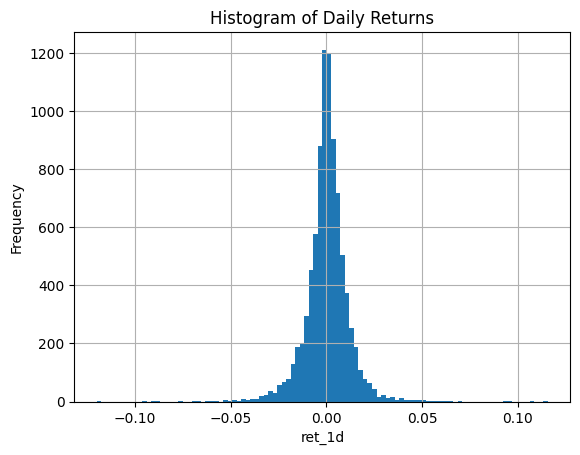

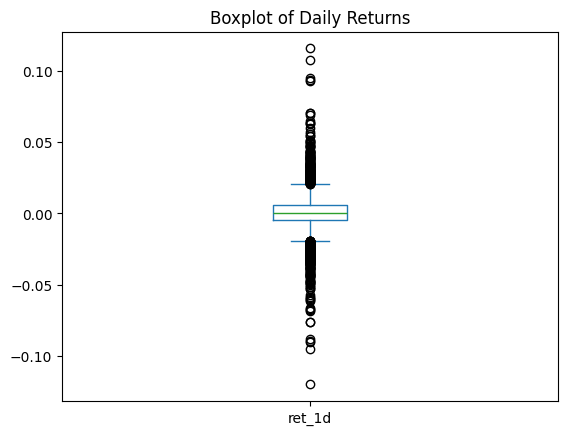

Shape after Return dropna: (8860, 36)


In [14]:

sp500["ret_1d"] = sp500["Close"].pct_change()
print(
    sp500["ret_1d"].describe(
        percentiles=[0.01, 0.05, 0.95, 0.99]
    )
)
# Visual inspection
sp500["ret_1d"].hist(bins=100)
plt.title("Histogram of Daily Returns")
plt.xlabel("ret_1d")
plt.ylabel("Frequency")
plt.show()
sp500[["ret_1d"]].plot(kind="box")
plt.title("Boxplot of Daily Returns")
plt.show()
sp500 = sp500.dropna().copy()
print("Shape after Return dropna:", sp500.shape)

Standardization

In [15]:
scaler = StandardScaler()
def scale_train_test(X_train, X_test):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

check if there is a Categorical encoding

In [16]:
cat_cols = sp500.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)
if len(cat_cols) > 0:
    sp500 = pd.get_dummies(sp500, columns=cat_cols, drop_first=True)
    print("One-hot encoding applied. New shape:", sp500.shape)
else:
    print("No categorical columns found. No encoding needed.")

Categorical columns: []
No categorical columns found. No encoding needed.


Balancing classes

In [17]:
class_counts = sp500["Target"].value_counts()
print("Class counts:\n", class_counts)
print("\nClass proportions:\n", class_counts / class_counts.sum())

Class counts:
 Target
1    4760
0    4100
Name: count, dtype: int64

Class proportions:
 Target
1    0.537246
0    0.462754
Name: count, dtype: float64


In [18]:
# balancing by upsampling
from sklearn.utils import resample
df_majority = sp500[sp500["Target"] == class_counts.idxmax()]
df_minority = sp500[sp500["Target"] == class_counts.idxmin()]
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)
sp500_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)
print("Balanced class counts:\n", sp500_balanced["Target"].value_counts())

Balanced class counts:
 Target
0    4760
1    4760
Name: count, dtype: int64


Summary statistics

In [19]:
sp500.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,8860.0,1.847801e+03,1.434643e+03,2.987500e+02,9.554075e+02,1.314245e+03,2.343367e+03,6.910950e+03
High,8860.0,1.858409e+03,1.441680e+03,3.015000e+02,9.655000e+02,1.322395e+03,2.352652e+03,6.920340e+03
Low,8860.0,1.836451e+03,1.426977e+03,2.977900e+02,9.495925e+02,1.305035e+03,2.335223e+03,6.870730e+03
Close,8860.0,1.848179e+03,1.434826e+03,2.987600e+02,9.554250e+02,1.314350e+03,2.346275e+03,6.901000e+03
Volume,8860.0,2.626747e+09,1.860531e+09,0.000000e+00,8.058000e+08,2.909510e+09,3.952142e+09,1.145623e+10
Tomorrow,8860.0,1.848919e+03,1.435729e+03,2.987600e+02,9.555650e+02,1.314455e+03,2.347527e+03,6.909790e+03
Target,8860.0,5.372460e-01,4.986389e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
ret_1d,8860.0,4.175078e-04,1.140337e-02,-1.198406e-01,-4.349453e-03,5.973346e-04,5.722301e-03,1.158004e-01
ret_2d,8860.0,8.245635e-04,1.542013e-02,-1.393331e-01,-6.428333e-03,1.401516e-03,8.788016e-03,1.320637e-01
ret_3d,8860.0,1.233499e-03,1.856196e-02,-1.390590e-01,-7.629102e-03,2.231493e-03,1.093787e-02,1.755029e-01


In [20]:
summary_extra = pd.DataFrame({
    "mean": sp500.mean(numeric_only=True),
    "median": sp500.median(numeric_only=True),
    "variance": sp500.var(numeric_only=True)
})
summary_extra

,mean,median,variance
Open,1.847801e+03,1.314245e+03,2.058201e+06
High,1.858409e+03,1.322395e+03,2.078442e+06
Low,1.836451e+03,1.305035e+03,2.036264e+06
Close,1.848179e+03,1.314350e+03,2.058726e+06
Volume,2.626747e+09,2.909510e+09,3.461575e+18
Tomorrow,1.848919e+03,1.314455e+03,2.061318e+06
Target,5.372460e-01,1.000000e+00,2.486408e-01
ret_1d,4.175078e-04,5.973346e-04,1.300367e-04
ret_2d,8.245635e-04,1.401516e-03,2.377804e-04
ret_3d,1.233499e-03,2.231493e-03,3.445463e-04


Visualizations

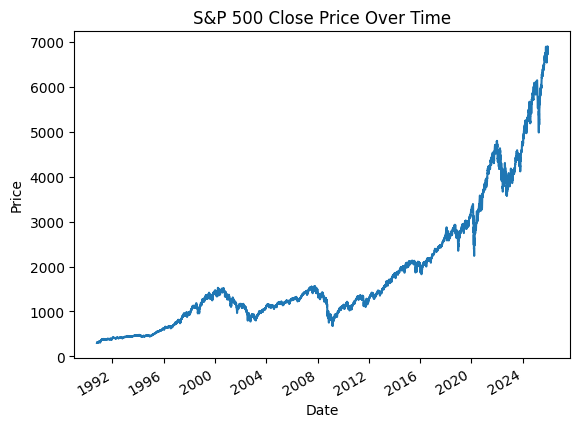

In [21]:
sp500["Close"].plot(title="S&P 500 Close Price Over Time")
plt.ylabel("Price")
plt.show()

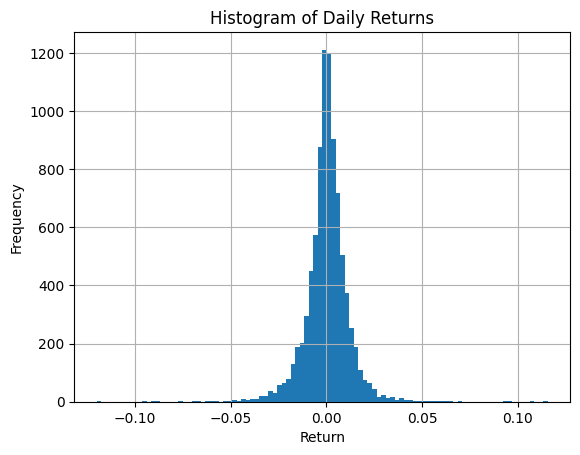

In [22]:
sp500["ret_1d"].hist(bins=100)
plt.title("Histogram of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

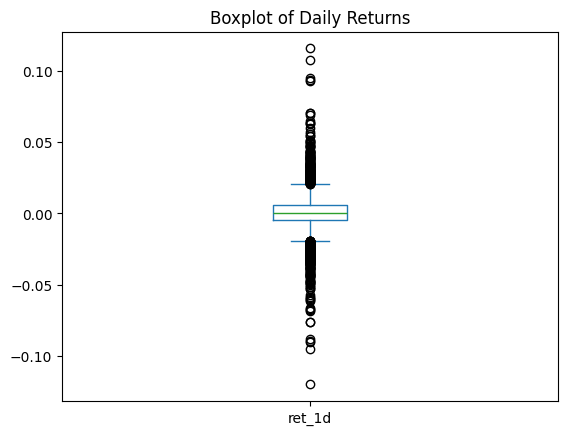

In [23]:
sp500[["ret_1d"]].plot(kind="box")
plt.title("Boxplot of Daily Returns")
plt.show()

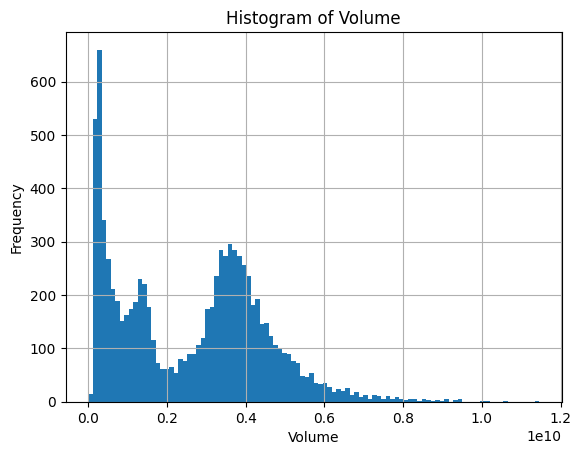

In [24]:
sp500["Volume"].hist(bins=100)
plt.title("Histogram of Volume")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.show()

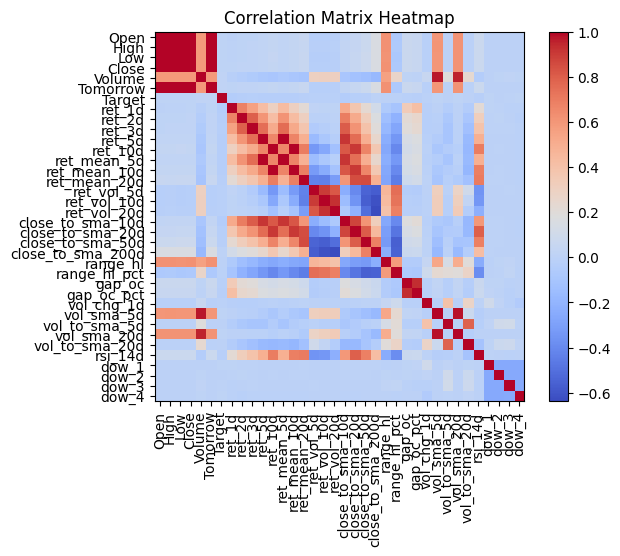

In [45]:
corr = sp500.corr(numeric_only=True)
plt.figure()
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.title("Correlation Matrix Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

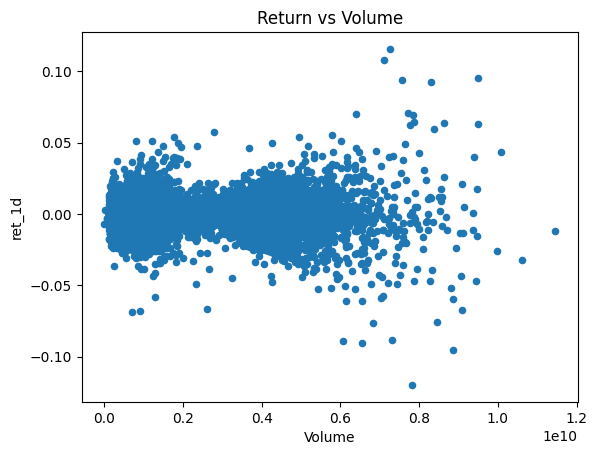

In [26]:
sp500.plot.scatter(x="Volume", y="ret_1d", title="Return vs Volume")
plt.show()

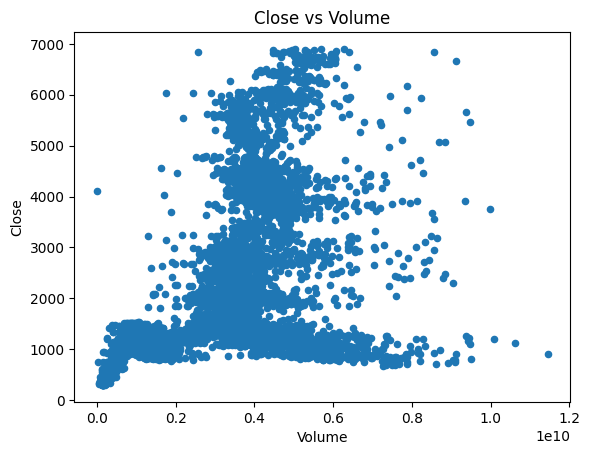

In [46]:
sp500.plot.scatter(x="Volume", y="Close", title="Close vs Volume")
plt.show()

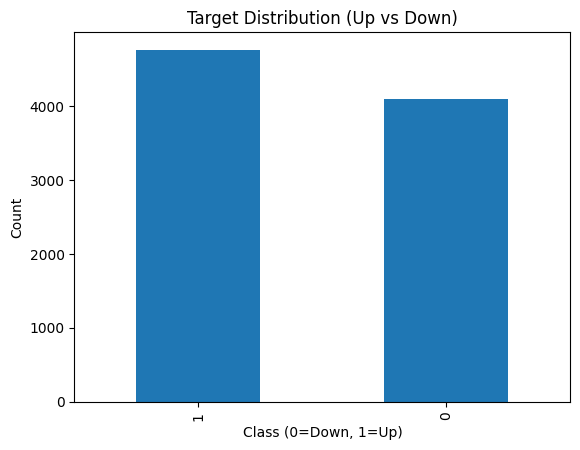

Target
1    0.537246
0    0.462754
Name: proportion, dtype: float64

In [28]:
sp500["Target"].value_counts().plot(kind="bar", title="Target Distribution (Up vs Down)")
plt.xlabel("Class (0=Down, 1=Up)")
plt.ylabel("Count")
plt.show()
sp500["Target"].value_counts(normalize=True)

relationships

In [29]:
sp500.groupby("Target")[["ret_1d", "Volume", "Close"]].mean()

,ret_1d,Volume,Close
Target,,,
0,0.000925,2.596549e+09,1832.184287
1,-0.000019,2.652757e+09,1861.956402


distribution

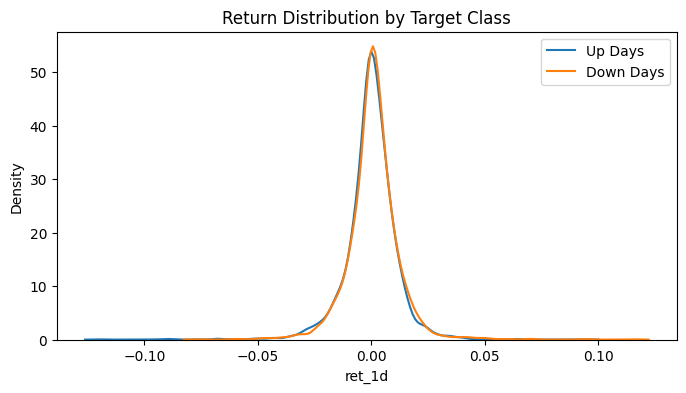

In [30]:
plt.figure(figsize=(8, 4))
sns.kdeplot(sp500.loc[sp500["Target"] == 1, "ret_1d"], label="Up Days")
sns.kdeplot(sp500.loc[sp500["Target"] == 0, "ret_1d"], label="Down Days")
plt.title("Return Distribution by Target Class")
plt.legend()
plt.show()

Modeling

In [31]:
feature_cols = sp500.select_dtypes(include="number").columns.tolist()
for col in ["Target", "Tomorrow"]:
    if col in feature_cols:
        feature_cols.remove(col)
        
X = sp500[feature_cols].copy()
y = sp500["Target"].copy()

Train, Test, Split

In [32]:
split_idx = int(len(sp500) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train dates:", X_train.index.min(), "->", X_train.index.max())
print("Test dates:", X_test.index.min(), "->", X_test.index.max())

Train: (7088, 30) Test: (1772, 30)
Train dates: 1990-10-16 00:00:00 -> 2018-11-30 00:00:00
Test dates: 2018-12-03 00:00:00 -> 2025-12-22 00:00:00


In [33]:
tscv = TimeSeriesSplit(n_splits=5)

In [34]:
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000, class_weight="balanced"))
])
lr_param_grid = {
    "lr__C": [0.01, 0.1, 1, 10],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"]
}
lr_grid = GridSearchCV(
    lr_pipe,
    lr_param_grid,
    cv=tscv,
    scoring="roc_auc",
    n_jobs=-1
)
lr_grid.fit(X_train, y_train)
print("Logistic Regression best params:", lr_grid.best_params_)
best_lr = lr_grid.best_estimator_
lr_prob = best_lr.predict_proba(X_test)[:, 1]
lr_pred = best_lr.predict(X_test)

Logistic Regression best params: {'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


In [35]:
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, class_weight="balanced"))
])
svm_param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", 0.1, 0.01]
}
svm_grid = GridSearchCV(
    svm_pipe,
    svm_param_grid,
    cv=tscv,
    scoring="roc_auc",
    n_jobs=-1
)
svm_grid.fit(X_train, y_train)
print("SVM best params:", svm_grid.best_params_)
best_svm = svm_grid.best_estimator_
svm_prob = best_svm.predict_proba(X_test)[:, 1]
svm_pred = best_svm.predict(X_test)

SVM best params: {'svm__C': 1, 'svm__gamma': 0.01}


In [36]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 10, 50]
}
rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=tscv,
    scoring="roc_auc",
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
print("Random Forest best params:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_
rf_prob = best_rf.predict_proba(X_test)[:, 1]
rf_pred = best_rf.predict(X_test)

Random Forest best params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 500}


In [37]:
print("y_test shape:", y_test.shape)
print("LR preds:", lr_pred.shape)
print("SVM preds:", svm_pred.shape)
print("RF preds:", rf_pred.shape)

y_test shape: (1772,)
LR preds: (1772,)
SVM preds: (1772,)
RF preds: (1772,)


Evaluation

In [38]:
cm_lr  = confusion_matrix(y_test, lr_pred)
cm_svm = confusion_matrix(y_test, svm_pred)
cm_rf  = confusion_matrix(y_test, rf_pred)

print("Logistic Regression CM:\n", cm_lr)
print("\nSVM CM:\n", cm_svm)
print("\nRandom Forest CM:\n", cm_rf)


Logistic Regression CM:
 [[674 124]
 [825 149]]

SVM CM:
 [[605 193]
 [752 222]]

Random Forest CM:
 [[758  40]
 [941  33]]


In [39]:
def metrics_row(name, y_true, y_pred, y_prob):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }
results = []
results.append(metrics_row("Logistic Regression", y_test, lr_pred, lr_prob))
results.append(metrics_row("SVM (RBF)", y_test, svm_pred, svm_prob))
results.append(metrics_row("Random Forest", y_test, rf_pred, rf_prob))
results_df = pd.DataFrame(results)
results_df.set_index("Model").round(4)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Model,,,,,
Logistic Regression,0.4644,0.5458,0.1530,0.2390,0.5145
SVM (RBF),0.4667,0.5349,0.2279,0.3197,0.4906
Random Forest,0.4464,0.4521,0.0339,0.0630,0.5235


Balancing 

In [40]:
def optional_metrics(name, y_true, y_pred):
    return {
        "Model": name,
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
        "MCC": matthews_corrcoef(y_true, y_pred),
        "Cohen Kappa": cohen_kappa_score(y_true, y_pred),
    }
opt_df = pd.DataFrame([
    optional_metrics("Logistic Regression", y_test, lr_pred),
    optional_metrics("SVM (RBF)", y_test, svm_pred),
    optional_metrics("Random Forest", y_test, rf_pred),
])
opt_df.set_index("Model").round(4)

,Balanced Accuracy,MCC,Cohen Kappa
Model,,,
Logistic Regression,0.4988,-0.0033,-0.0022
SVM (RBF),0.4930,-0.0164,-0.0131
Random Forest,0.4919,-0.0407,-0.0147


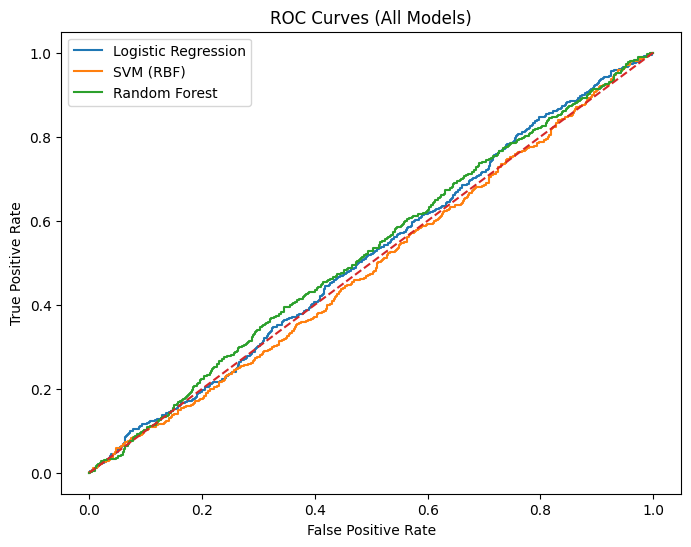

In [41]:
plt.figure(figsize=(8, 6))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_prob)
plt.plot(fpr_svm, tpr_svm, label="SVM (RBF)")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

# baseline diagonal
plt.plot([0, 1], [0, 1], linestyle="--")

plt.title("ROC Curves (All Models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [42]:
y_test.value_counts(normalize=True)

Target
1    0.549661
0    0.450339
Name: proportion, dtype: float64